# NN implemetation with Pythorch

# Imports

In [96]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Utils functions and classes

In [97]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [98]:
# Funzione per normalizzare i dati
def normalize(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data

In [99]:
def split_data(data, labels, k=5):
    """
    Divide i dati in k fold.
    
    Args:
        data (np.ndarray | pd.DataFrame): Dati di input.
        labels (np.ndarray | pd.Series): Etichette.
        k (int): Numero di fold.
    
    Returns:
        list: Lista di tuple (fold_data, fold_labels).
    """
    if not isinstance(data, np.ndarray):
        data = data.to_numpy()  # Converte DataFrame in NumPy array
    if not isinstance(labels, np.ndarray):
        labels = labels.to_numpy()  # Converte Series in NumPy array
    
    data = normalize(data)

    fold_size = len(data) // k
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    folds = []

    for i in range(k):
        fold_indices = indices[i * fold_size: (i + 1) * fold_size]
        fold_data = data[fold_indices]
        fold_labels = labels[fold_indices]
        folds.append((fold_data, fold_labels))
    
    return folds

In [100]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Genera tutte le combinazioni di iperparametri basate su range e step specificati.

    :param param_ranges: Dizionario con i nomi degli iperparametri come chiavi.
                         Ogni valore è una tupla (start, stop, step).
    :return: Lista di dizionari con tutte le combinazioni possibili.
    """
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    param_combinations = list(itertools.product(*param_values.values()))
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

## Model creation, train and evaluation

In [101]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers, alpha):
        super(NN, self).__init__()
        self.fc_input = nn.Linear(input_size, hidden_size)
        self.fc_hidden = [None] * (hidden_layers-1)
        for i in range(hidden_layers-1):
            self.fc_hidden[i] = nn.Linear(hidden_size, hidden_size)
        self.fc_output = nn.Linear(hidden_size, output_size)
        self.leacky_relu = nn.LeakyReLU(alpha)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.leacky_relu(self.fc_input(x))
        for i in range(len(self.fc_hidden)):
            x = self.leacky_relu(self.fc_hidden[i](x))
        x = self.sigmoid(self.fc_output(x))
        return x

In [102]:
def fit(data_loader, model, learning_rate, momentum, weight_decay, epochs, val_data=[], val_labels=[]):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.SGD(
        model.parameters(), 
        lr=learning_rate, 
        momentum=momentum, 
        nesterov=True, 
        weight_decay=weight_decay
    )
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    # Addestramento
    for epoch in range(epochs):
        model.train()
        correct_predictions = 0  
        total_samples = 0  
        last_loss = 0 
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Reset dei gradienti
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels.unsqueeze(1))  # Calcolo della perdita
            loss.backward()  # Backpropagation
            optimizer.step()  # Aggiornamento dei pesi

            last_loss = loss.item()  # Memorizziamo l'ultima perdita

            # Calcolo dell'accuratezza
            predicted = (outputs >= 0.5).float()  # La soglia 0.5 per classificazione binaria
            correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()  # Somma delle previsioni corrette
            total_samples += labels.size(0)  # Numero totale di esempi nel batch


        # Calcolo dell'accuratezza del train per epoca
        accuracy = 100 * correct_predictions / total_samples
        history['train_loss'].append(last_loss)
        history['train_accuracy'].append(accuracy)

        #validazione di quell'epoca
        if val_data is not None and val_labels is not None and len(val_data) > 0 and len(val_labels) > 0:
            result = evaluation(model, val_data, val_labels, criterion)
            history['val_loss'].append(result[0])
            history['val_accuracy'].append(result[1])
    return history

def evaluation(model, X, Y, criterion):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        labels = torch.tensor(Y, dtype=torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        predictions = (outputs.squeeze() > 0.5).float()  # Soglia 0.5 per classificazione
        accuracy = (predictions == labels.unsqueeze(1)).float().mean()
        print("CULOOOOOOOOOOOOOOOO")
        print(accuracy)
        return [loss,accuracy]


## Double-k-fold cross validation

In [103]:
def double_k_fold_cross_validation(data, labels, in_size = 6, out_size = 1, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implementa una Double K-Fold Cross-Validation

    Args:
        data (np.ndarray): Caratteristiche del dataset.
        labels (np.ndarray): Etichette del dataset.
        outer_k (int): Numero di fold per la validazione esterna.
        inner_k (int): Numero di fold per l'ottimizzazione iperparametri.
        param_grid (list): Lista di dizionari con gli iperparametri da provare.
    
    Returns:
        list: Lista dei punteggi ottenuti per ogni fold esterno.
    """
    outer_scores = []
    outer_params = []
    outer_folds = split_data(data, labels, k=outer_k)
    
    for i in range(outer_k):
        print("Outer fold", i + 1)
        outer_test_data, outer_test_labels = outer_folds[i]
        outer_train_data = np.concatenate([fold[0] for j, fold in enumerate(outer_folds) if j != i])
        outer_train_labels = np.concatenate([fold[1] for j, fold in enumerate(outer_folds) if j != i])
        
        best_params = {}
        best_score = -np.inf
        
        # Validazione interna per ottimizzazione iperparametri
        inner_folds = split_data(outer_train_data, outer_train_labels, k=inner_k)

        for params in param_grid:
            inner_scores = []
            
            for j in range(inner_k):
                inner_val_data, inner_val_labels = inner_folds[j]
                inner_train_data = np.concatenate([fold[0] for l, fold in enumerate(inner_folds) if l != j])
                inner_train_labels = np.concatenate([fold[1] for l, fold in enumerate(inner_folds) if l != j])
                dataset = CustomDataset(inner_train_data, inner_train_labels)
                data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)
                # Creazione della rete neurale
                model = NN(input_size = in_size, hidden_size = params['hidden_size'], output_size = out_size, 
                           hidden_layers = params['hidden_layers'], alpha=params['alpha'])
                # Allena il modello e ottieni la cronologia (history)
                history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'],
                              weight_decay=params['regularization'], momentum=params['momentum'],
                              epochs=params['epochs'], val_data=inner_val_data, val_labels=inner_val_labels)
    
                inner_scores.append(max(history['val_accuracy'])
)
            
            avg_score = np.mean(inner_scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        
        # Addestramento finale sul set di train esterno
        dataset = CustomDataset(outer_train_data, outer_train_labels)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)
        final_model = NN(input_size = in_size, hidden_size = params['hidden_size'], output_size = out_size, 
                         hidden_layers = params['hidden_layers'], alpha=params['alpha'])
        history = fit(data_loader=data_loader, model=final_model, learning_rate=params['learning_rate'],
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], val_data=outer_test_data, val_labels=outer_test_labels)
        outer_scores.append(max(history['val_accuracy']))
        outer_params.append(best_params)
    
    return outer_scores, outer_params

## K-fold cross validation

In [104]:
def k_fold_cross_validation(data, labels, in_size, out_size, k=5, params = None):
    """
    Implementa una K-Fold Cross-Validation
    """
    scores = []
    folds = split_data(data, labels, k=k)


    for i in range(k):

        # Creazione della rete neurale
        model = NN(input_size = in_size, hidden_size = params['hidden_size'], output_size = out_size,
                   hidden_layers = params['hidden_layers'], alpha=params['alpha'])
        test_data, test_labels = folds[i]

        train_data = np.concatenate([fold[0] for j, fold in enumerate(folds) if j != i])
        train_labels = np.concatenate([fold[1] for j, fold in enumerate(folds) if j != i])
        dataset = CustomDataset(train_data, train_labels)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], val_data=test_data, val_labels=test_labels)
        
        score = max(history['val_accuracy'])
        scores.append(score)
            
    avg_score = np.mean(scores)

    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    dataset = CustomDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)


    model = NN(input_size = in_size, hidden_size = params['hidden_size'], output_size = out_size,
               hidden_layers = params['hidden_layers'], alpha=params['alpha'])
        
    
    history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], val_data=X_val, val_labels=y_val)


    return avg_score, history, model

## Data loading

In [105]:
# Carica i file di addestramento e test per ciascun dataset dal percorso specificato
monk1_train = pd.read_csv('../Datasets/Monks/monks-1.train', sep='\s+', header=None)
monk1_test = pd.read_csv('../Datasets/Monks/monks-1.test', sep='\s+', header=None)

monk2_train = pd.read_csv('../Datasets/Monks/monks-2.train', sep='\s+', header=None)
monk2_test = pd.read_csv('../Datasets/Monks/monks-2.test', sep='\s+', header=None)

monk3_train = pd.read_csv('../Datasets/Monks/monks-3.train', sep='\s+', header=None)
monk3_test = pd.read_csv('../Datasets/Monks/monks-3.test', sep='\s+', header=None)


# Separazione tra features e labels per monk1
X1_train = monk1_train.iloc[:, 1:7].values  # Caratteristiche (features)
y1_train = monk1_train.iloc[:, 0].values   # Etichette (labels)

X1_test = monk1_test.iloc[:, 1:7].values
y1_test = monk1_test.iloc[:, 0].values

# Separazione tra features e labels per monk2
X2_train = monk2_train.iloc[:, 1:7].values
y2_train = monk2_train.iloc[:, 0].values

X2_test = monk2_test.iloc[:, 1:7].values
y2_test = monk2_test.iloc[:, 0].values

# Separazione tra features e labels per monk3
X3_train = monk3_train.iloc[:, 1:7].values
y3_train = monk3_train.iloc[:, 0].values

X3_test = monk3_test.iloc[:, 1:7].values
y3_test = monk3_test.iloc[:, 0].values

In [106]:
# Definisce i parametri della rete neurale
input_size = 6
output_size = 1

# Definizione dei range degli iperparametri
param_ranges = {
    "learning_rate": (0.01, 0.9, 0.01),  # Da 0.001 a 0.01 con step di 0.005
    "epochs": (50, 200, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 16, 4),             # Da 8 a 32 con step di 8
    "hidden_size": (1, 2, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 3, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.01, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.001, 0.1, 0.05),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01)              # Da 0.01 a 0.1 con step di 0.05
}

#start_time = time.time()
print("Generazione delle combinazioni di iperparametri...")
param_grid = []
param_grid = generate_hyperparameter_combinations(param_ranges)
#end_time = time.time()

#execution_time = end_time - start_time
#print(f"Tempo di esecuzione di generate_hyperparameter_combinations: {execution_time} secondi")

best_scores = []  # Usa una lista normale per memorizzare i punteggi
best_params_list = []  # Lista per le configurazioni
best_models = []  # Lista per i modelli
best_histories = []  # Lista per la storia di allenamento

# Seleziona 100 elementi a caso senza rimpiazzamento
param_grid = np.random.choice(param_grid, size=100, replace=False)

for params in param_grid:
    print("--------------------------------------------------")
    print(f"Testing params: {params}")
    score, history, model = k_fold_cross_validation(X1_train, y1_train, in_size = input_size, out_size=output_size, k=5, params=params)
    print(f"Score : {score}")

    # Aggiungi i risultati alla lista
    best_scores.append(score)
    best_params_list.append(params)
    best_models.append(model)
    best_histories.append(history)

    # Ordina la lista dei punteggi e mantieni solo i migliori 10
    sorted_indices = np.argsort(best_scores)[::-1]  # Ordina i punteggi in ordine decrescente
    best_scores = [best_scores[i] for i in sorted_indices][:10]  # Usa la lista e mantieni i top 10
    best_params_list = [best_params_list[i] for i in sorted_indices][:10]
    best_models = [best_models[i] for i in sorted_indices][:10]
    best_histories = [best_histories[i] for i in sorted_indices][:10]

print("--------------------END GREED SEARCH------------------------------")

# Ora hai i 10 migliori risultati
print("Top 10 best scores:")
print(best_scores)
print("Top 10 best params:")
print(best_params_list)

Generazione delle combinazioni di iperparametri...
--------------------------------------------------
Testing params: {'learning_rate': 0.74, 'epochs': 164, 'batch_size': 16, 'hidden_size': 1, 'hidden_layers': 2, 'momentum': 0.21000000000000002, 'regularization': 0.101, 'alpha': 0.01}
Score : 0.472222238779068
--------------------------------------------------
Testing params: {'learning_rate': 0.45, 'epochs': 186, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.6100000000000001, 'regularization': 0.101, 'alpha': 0.01}
Score : 0.5104166269302368
--------------------------------------------------
Testing params: {'learning_rate': 0.8300000000000001, 'epochs': 62, 'batch_size': 16, 'hidden_size': 1, 'hidden_layers': 3, 'momentum': 0.91, 'regularization': 0.001, 'alpha': 0.01}
Score : 0.5416666865348816
--------------------------------------------------
Testing params: {'learning_rate': 0.5800000000000001, 'epochs': 122, 'batch_size': 4, 'hidden_size': 2, 'hidden_layer

In [107]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    - history: History object returned by model.fit().
    - params: Dictionary containing the model parameters.
    """

    # Estrai dati dalla history
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    
    epochs = range(1, len(train_loss) + 1)  # Numero di epoche

    # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

{'learning_rate': 0.24000000000000002, 'epochs': 125, 'batch_size': 4, 'hidden_size': 1, 'hidden_layers': 3, 'momentum': 0.81, 'regularization': 0.001, 'alpha': 0.01}


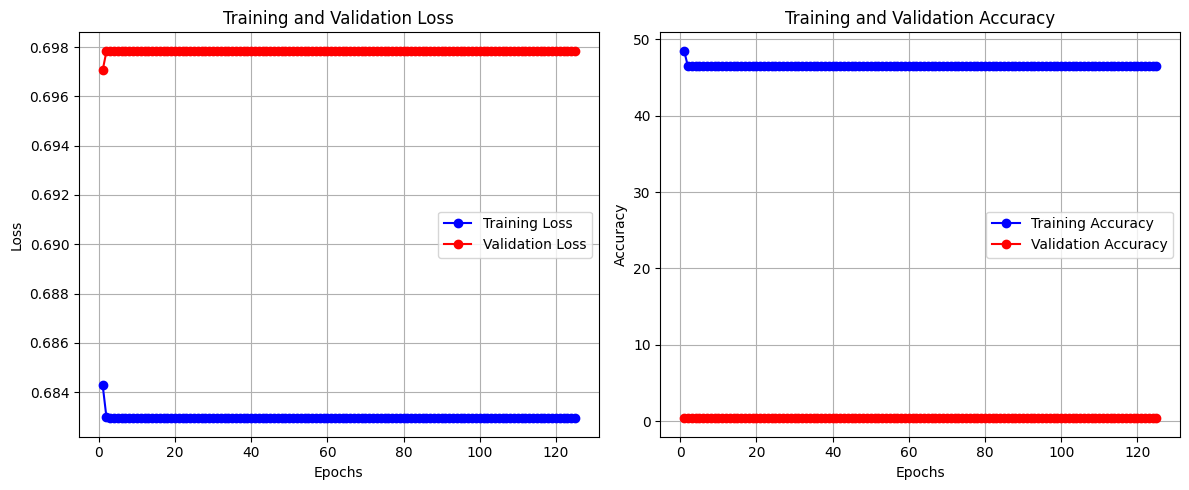

{'learning_rate': 0.55, 'epochs': 167, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 2, 'momentum': 0.91, 'regularization': 0.001, 'alpha': 0.01}


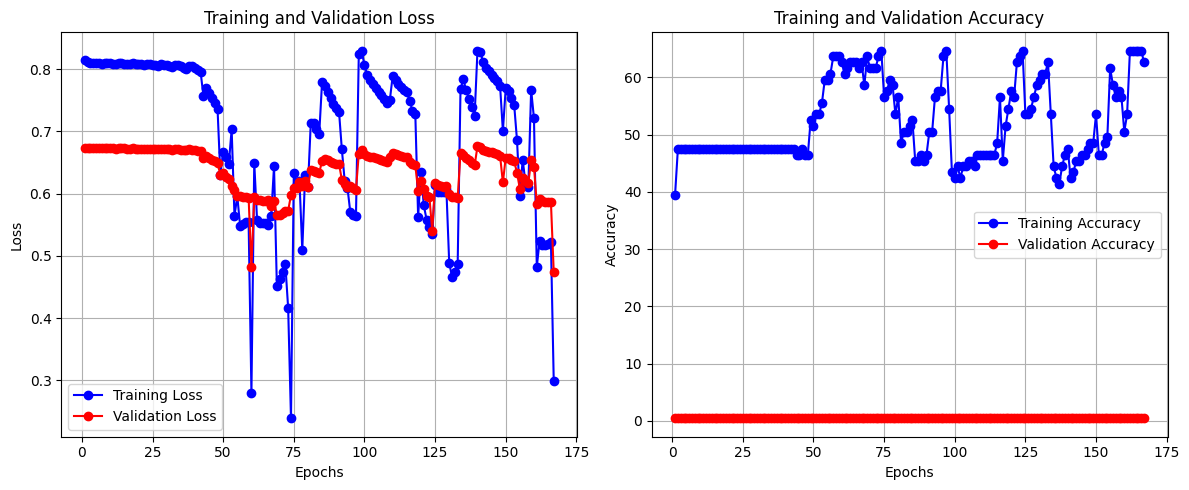

{'learning_rate': 0.49, 'epochs': 171, 'batch_size': 4, 'hidden_size': 1, 'hidden_layers': 2, 'momentum': 0.7100000000000001, 'regularization': 0.001, 'alpha': 0.01}


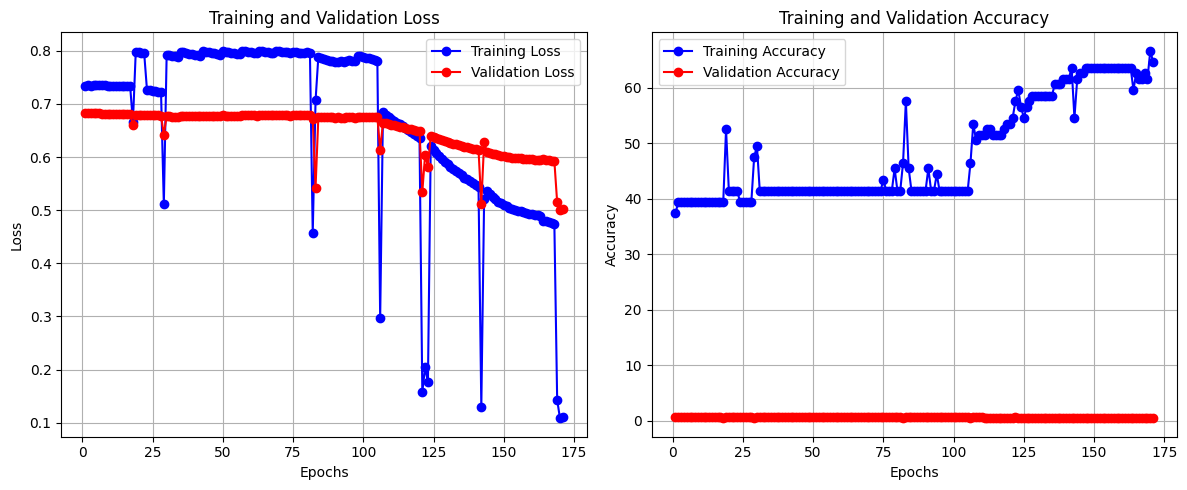

{'learning_rate': 0.46, 'epochs': 143, 'batch_size': 4, 'hidden_size': 1, 'hidden_layers': 1, 'momentum': 0.91, 'regularization': 0.101, 'alpha': 0.01}


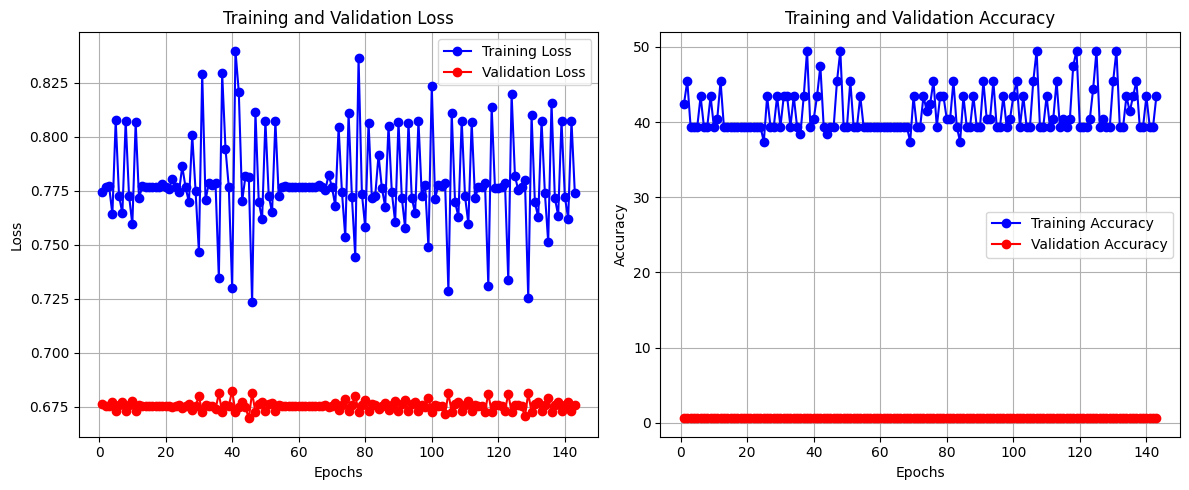

{'learning_rate': 0.33, 'epochs': 141, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 2, 'momentum': 0.31000000000000005, 'regularization': 0.001, 'alpha': 0.01}


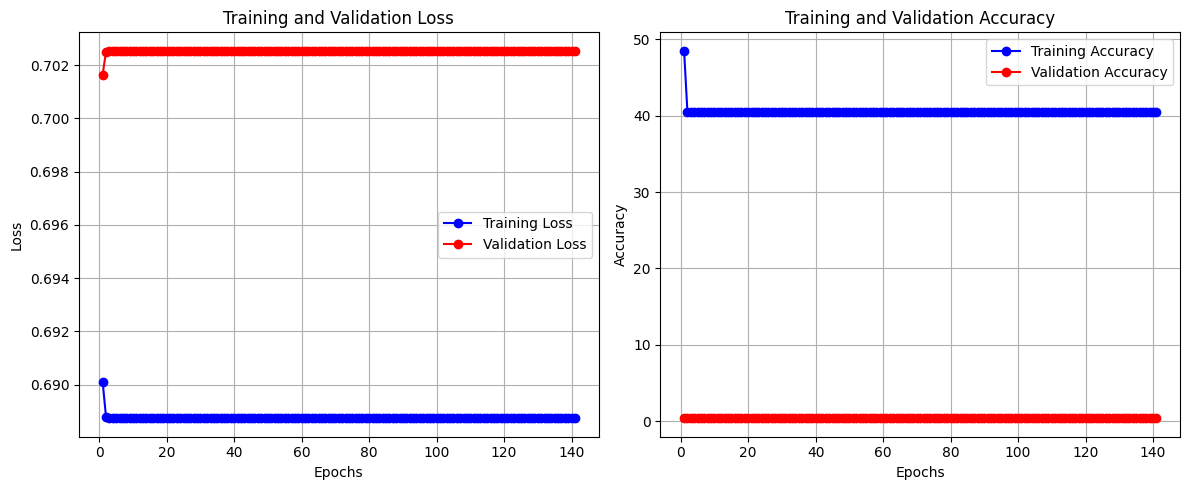

{'learning_rate': 0.6, 'epochs': 176, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 2, 'momentum': 0.7100000000000001, 'regularization': 0.001, 'alpha': 0.01}


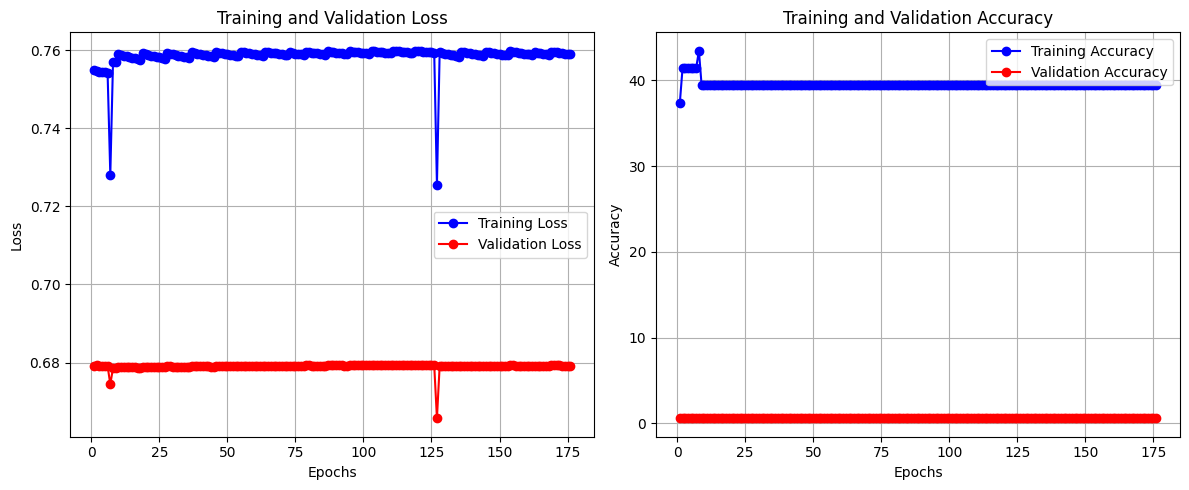

{'learning_rate': 0.13, 'epochs': 106, 'batch_size': 16, 'hidden_size': 2, 'hidden_layers': 3, 'momentum': 0.01, 'regularization': 0.001, 'alpha': 0.01}


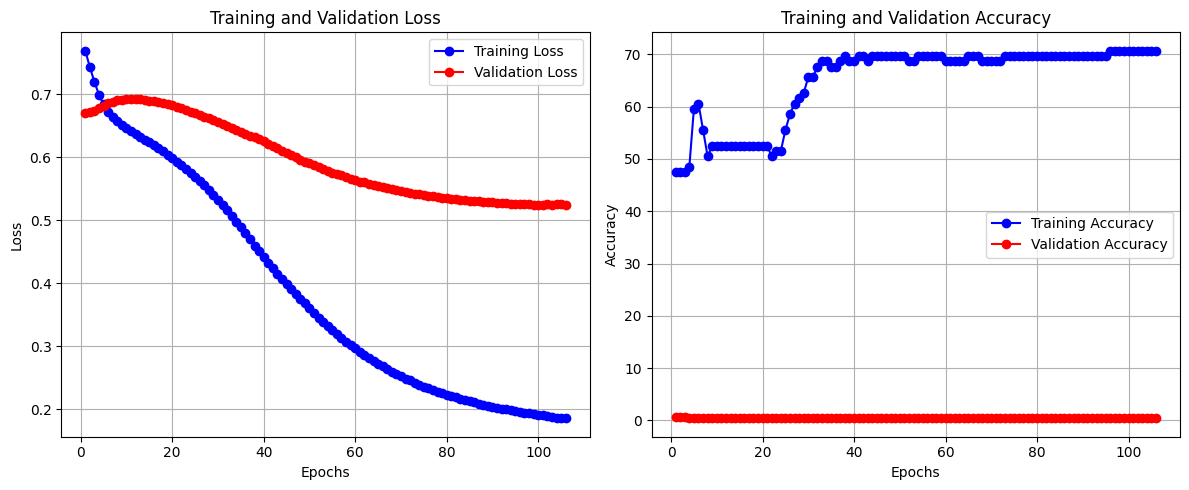

{'learning_rate': 0.09999999999999999, 'epochs': 80, 'batch_size': 12, 'hidden_size': 1, 'hidden_layers': 1, 'momentum': 0.51, 'regularization': 0.051000000000000004, 'alpha': 0.01}


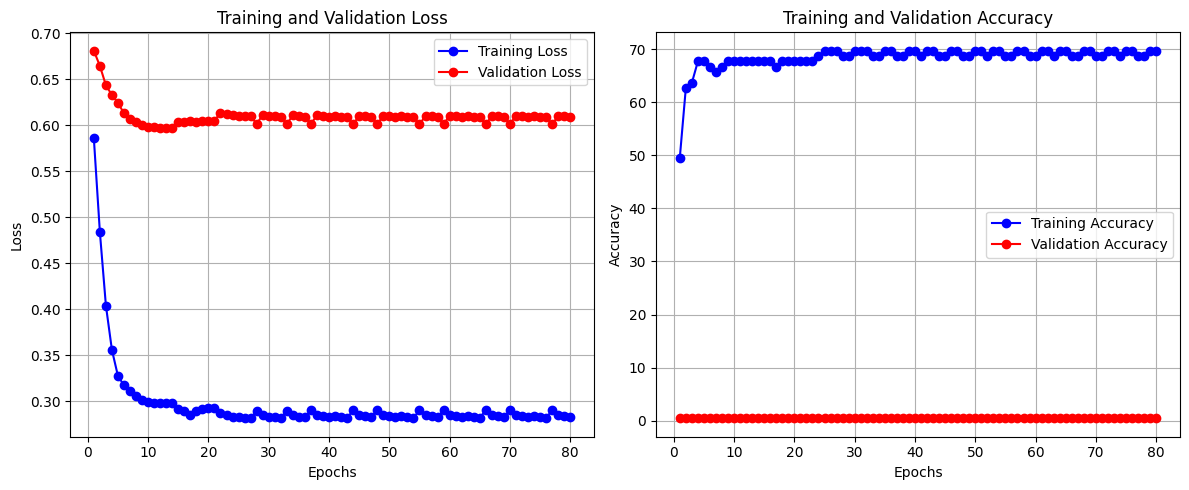

{'learning_rate': 0.61, 'epochs': 72, 'batch_size': 12, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.7100000000000001, 'regularization': 0.001, 'alpha': 0.01}


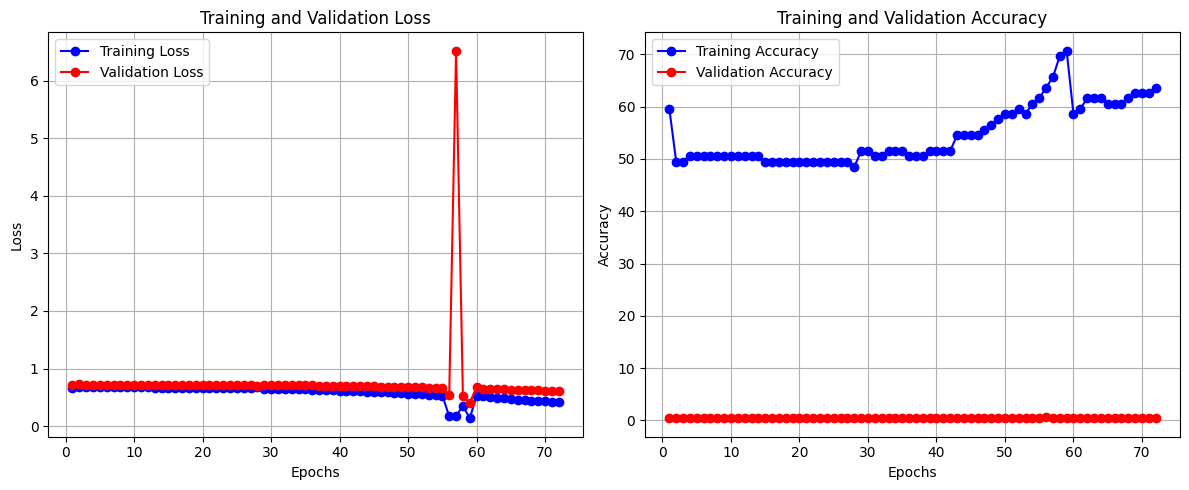

{'learning_rate': 0.03, 'epochs': 76, 'batch_size': 16, 'hidden_size': 1, 'hidden_layers': 1, 'momentum': 0.11, 'regularization': 0.101, 'alpha': 0.01}


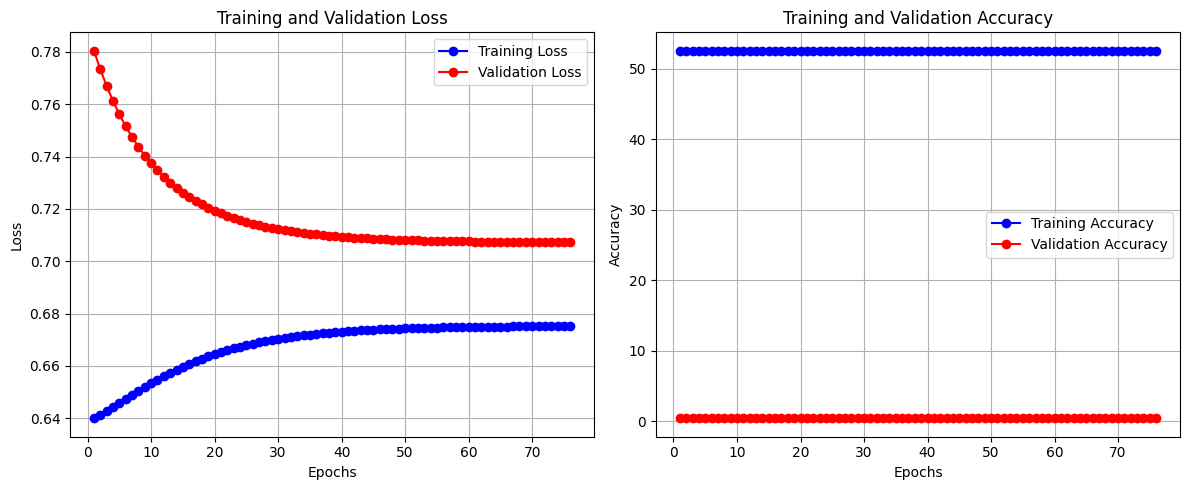

In [108]:
for i, (history, params) in enumerate(zip(best_histories, best_params_list)):
    print(f"{params}")
    plot_training_history(history)